In [1]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('bmh')

from metrics import cindex

from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV, SelectFromModel

from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter, AalenAdditiveFitter, LogNormalAFTFitter, LogLogisticAFTFitter, CoxTimeVaryingFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter

from utils import preprocess, predict, KME_score, tuned_regressors_to_json

## 1. Observation of the provided datasets
We use preprocessing function from ```utils.py```

We load feature datasets selecting only features that were considered for the benchmark model (see ```BASIC_FEATURES```in ```utils.py```)

In [22]:
select_features = 'basic'
train, dic_train = preprocess('train', separated_output=True, select_features=select_features, normalize=False)
test, dic_test = preprocess('test', separated_output=False, select_features=select_features, scaler=None)

In [23]:
output = dic_train['output']

Are there many missing values?

In [24]:
train.isna().mean()

original_shape_Sphericity            0.0
original_shape_SurfaceVolumeRatio    0.0
original_shape_VoxelVolume           0.0
SourceDataset                        0.0
Nstage                               0.0
original_glcm_JointEntropy           0.0
original_glcm_Id                     0.0
original_glcm_Idm                    0.0
dtype: float64

In [25]:
#train.dropna(inplace=True)

In [26]:
train.head()

,original_shape_Sphericity,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,SourceDataset,Nstage,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm
PatientID,,,,,,,,
202,0.650210,0.275228,19786.0,1,0,9.270194,0.338672,0.262780
371,0.573079,0.240727,43168.0,0,2,7.551168,0.495719,0.439879
246,0.642913,0.200766,52655.0,0,3,5.686554,0.616607,0.581458
240,0.634469,0.323878,13074.0,0,2,7.536161,0.457545,0.391681
284,0.584242,0.327241,16237.0,0,3,6.940307,0.544607,0.501892


In [27]:
output.head()

,SurvivalTime,Event
PatientID,,
202,1378,0
371,379,1
246,573,1
240,959,0
284,2119,0


### First univariate model: Kaplan Meier Estimate

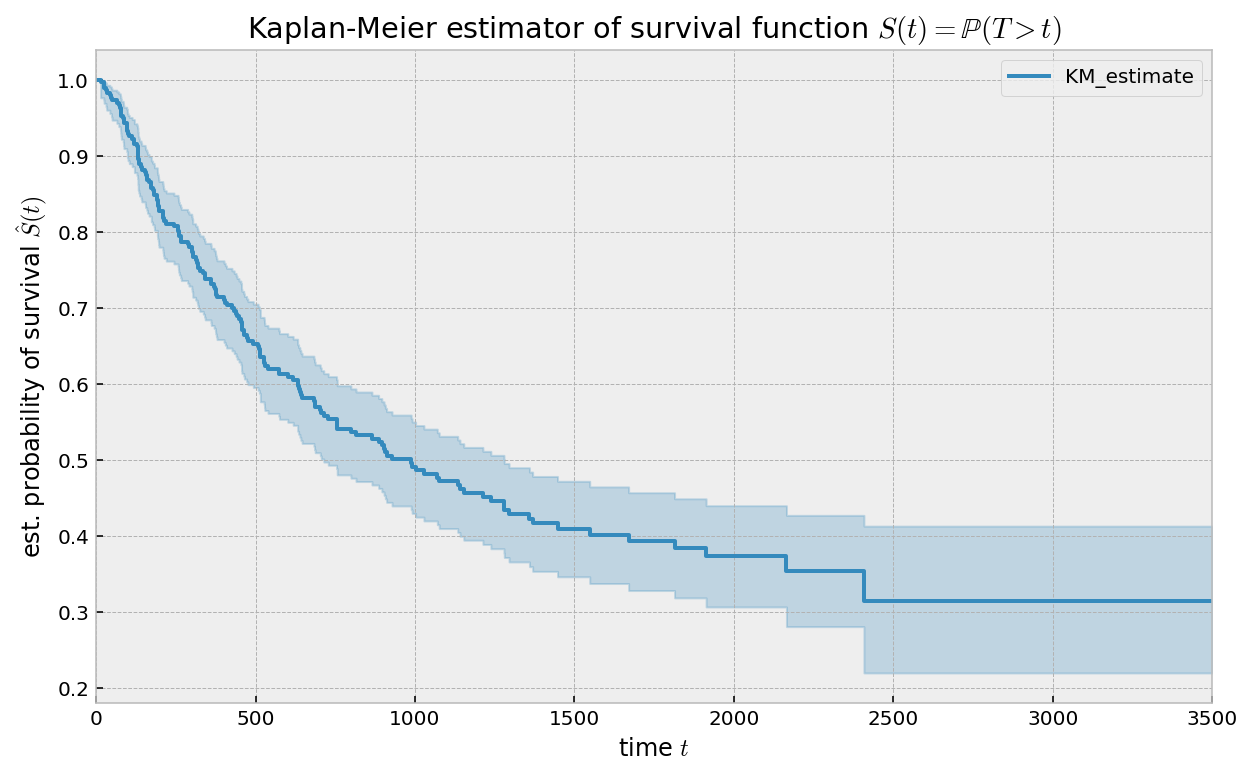

In [28]:
kmf = KaplanMeierFitter()

kmf.fit(output.SurvivalTime, event_observed=output.Event)

kmf.plot(figsize=(10, 6))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title("Kaplan-Meier estimator of survival function $S(t) = \mathbb{P}(T>t)$")
plt.show()

#### Importance of variable ```SourceDataset```

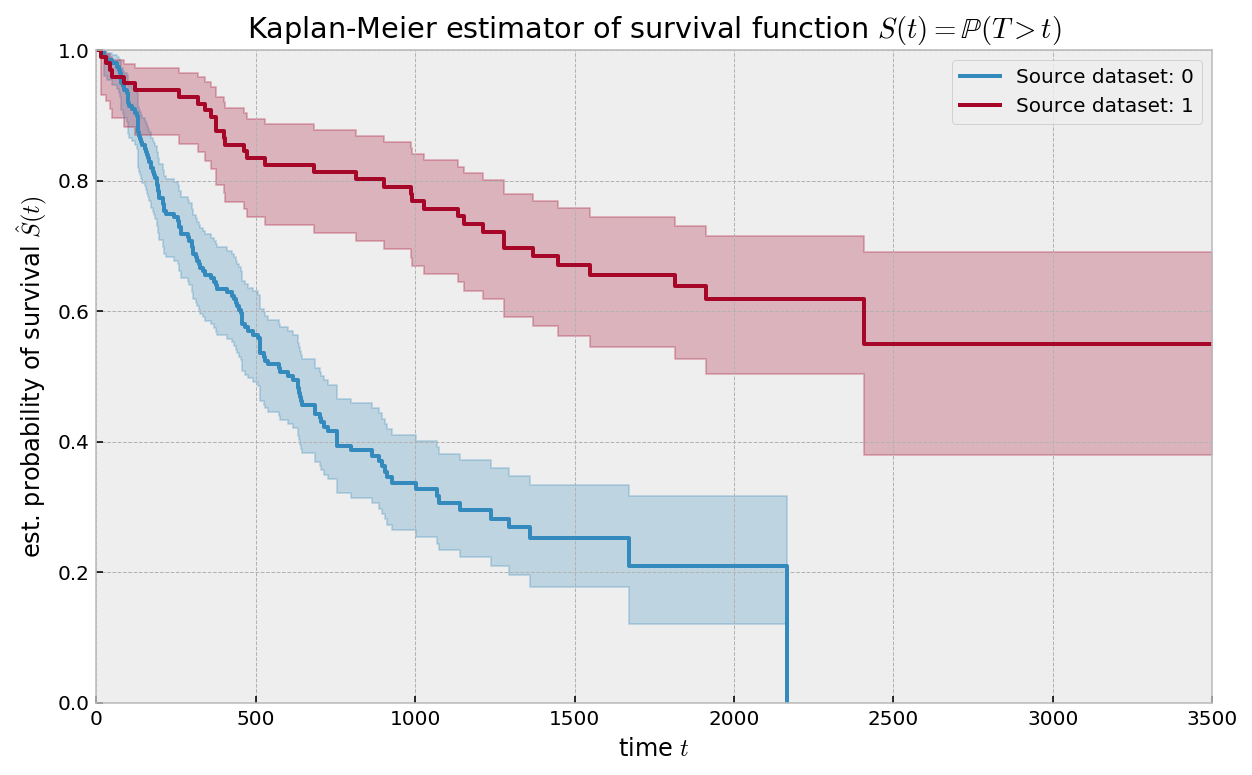

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

source_mask = (train.SourceDataset == 0)

kmf.fit(output.SurvivalTime[source_mask], event_observed=output.Event[source_mask], label="Source dataset: 0")
kmf.plot(ax=ax)
kmf.fit(output.SurvivalTime[~source_mask], event_observed=output.Event[~source_mask], label="Source dataset: 1")
kmf.plot(ax=ax)

plt.ylim(0, 1);
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title("Kaplan-Meier estimator of survival function $S(t) = \mathbb{P}(T>t)$")
plt.show()

It looks like it is relevant to take the variable ```SourceDataset```into account.

## 2. Reproducing benchmark with Cox-model

### Fitting basic Cox’s proportional hazard model

In [30]:
select_features = 'basic'
train, dic_train = preprocess('train', separated_output=False, select_features=select_features, normalize=True)
test, dic_test = preprocess('test', separated_output=False, select_features=select_features, scaler=dic_train['scaler'])

Normalize feature columns
Normalize feature columns with given scaler


We use ```CoxPHFitter```from ```lifelines```package to carry out the regression.

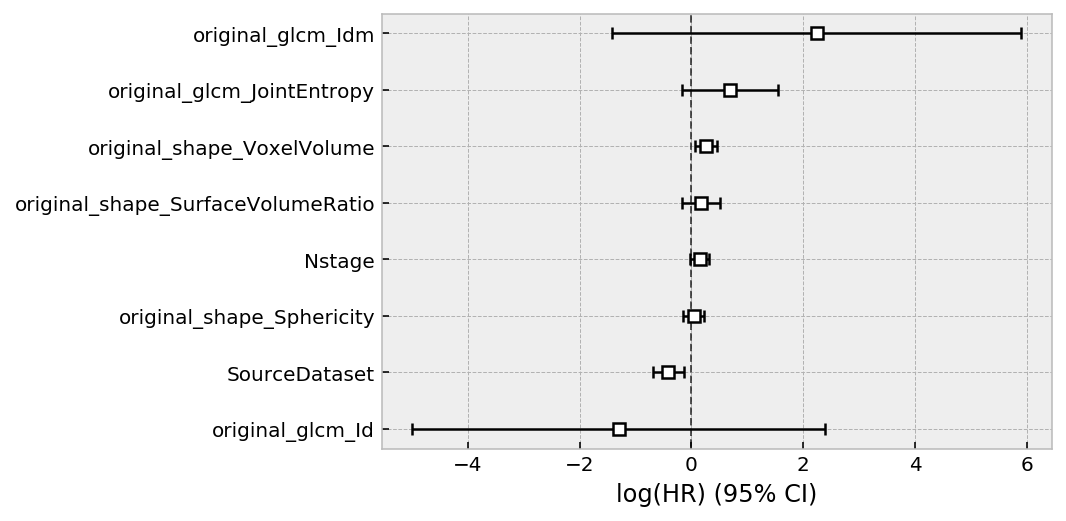

In [31]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(train, duration_col='SurvivalTime', event_col='Event')

cph.print_summary()
cph.plot()
plt.show()

We can check whether this model seems adapted.

In [34]:
cph.check_assumptions(train, show_plots=True)
print("c-index score: {:.3f}".format(cph.score_))

Proportional hazard assumption looks okay.
c-index score: 0.704


### Making a first prediction

In [35]:
prediction = predict(cph, test, True, filename='benchmark')
if prediction.index[0] in output.index:
    print(cindex(output.loc[prediction.index], prediction))
prediction.head()

,SurvivalTime,Event
PatientID,,
13,342.000000,nan
155,886.000000,nan
404,527.000000,nan
407,728.000000,nan
9,3218.410526,nan


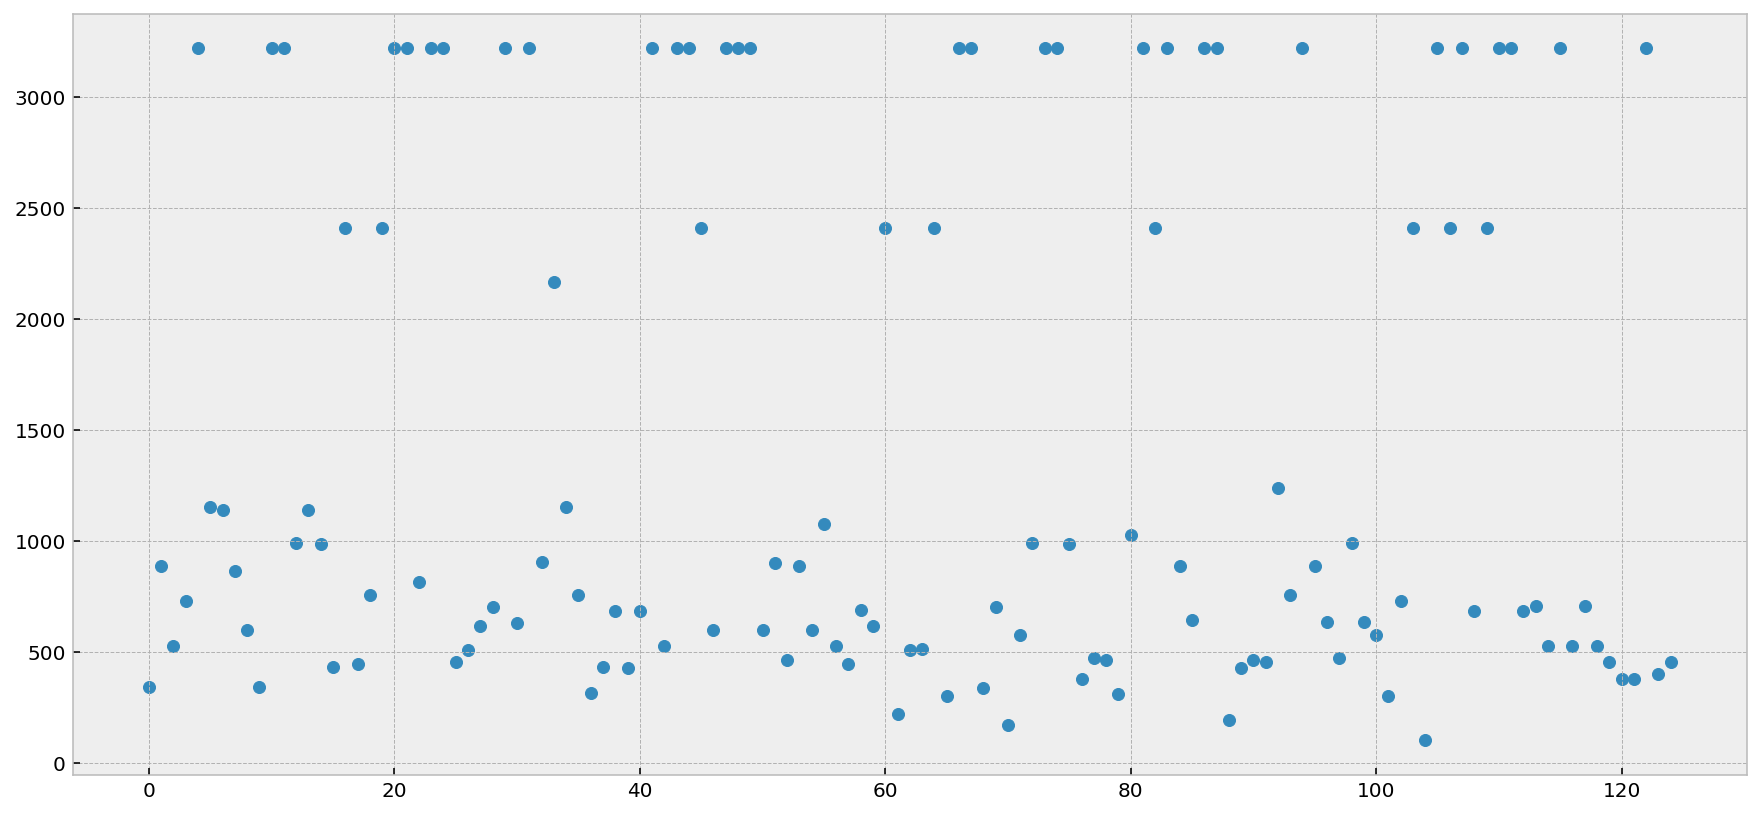

In [19]:
plt.figure(figsize=(15, 7))
if prediction.index[0] in output.index:
    plt.scatter(np.arange(output.index.shape[0]), output['SurvivalTime'])
plt.scatter(np.arange(prediction.index.shape[0]), prediction['SurvivalTime'])
plt.show()

## 3. Feature selection

### Feature selection using correlation matrix
We eliminate highly correlated variables based on Spearman's Cross Correlation matrix.

In [2]:
# load dataset with all features (except Histology and age for which there are missing values)
select_features = 'all-Histology-age'
train, dic_train = preprocess('train', separated_output=True, select_features=select_features, normalize=True)
test, dic_test = preprocess('test', separated_output=False, select_features=select_features, scaler=dic_train['scaler'])
output = dic_train['output']

Normalize feature columns
Normalize feature columns with given scaler


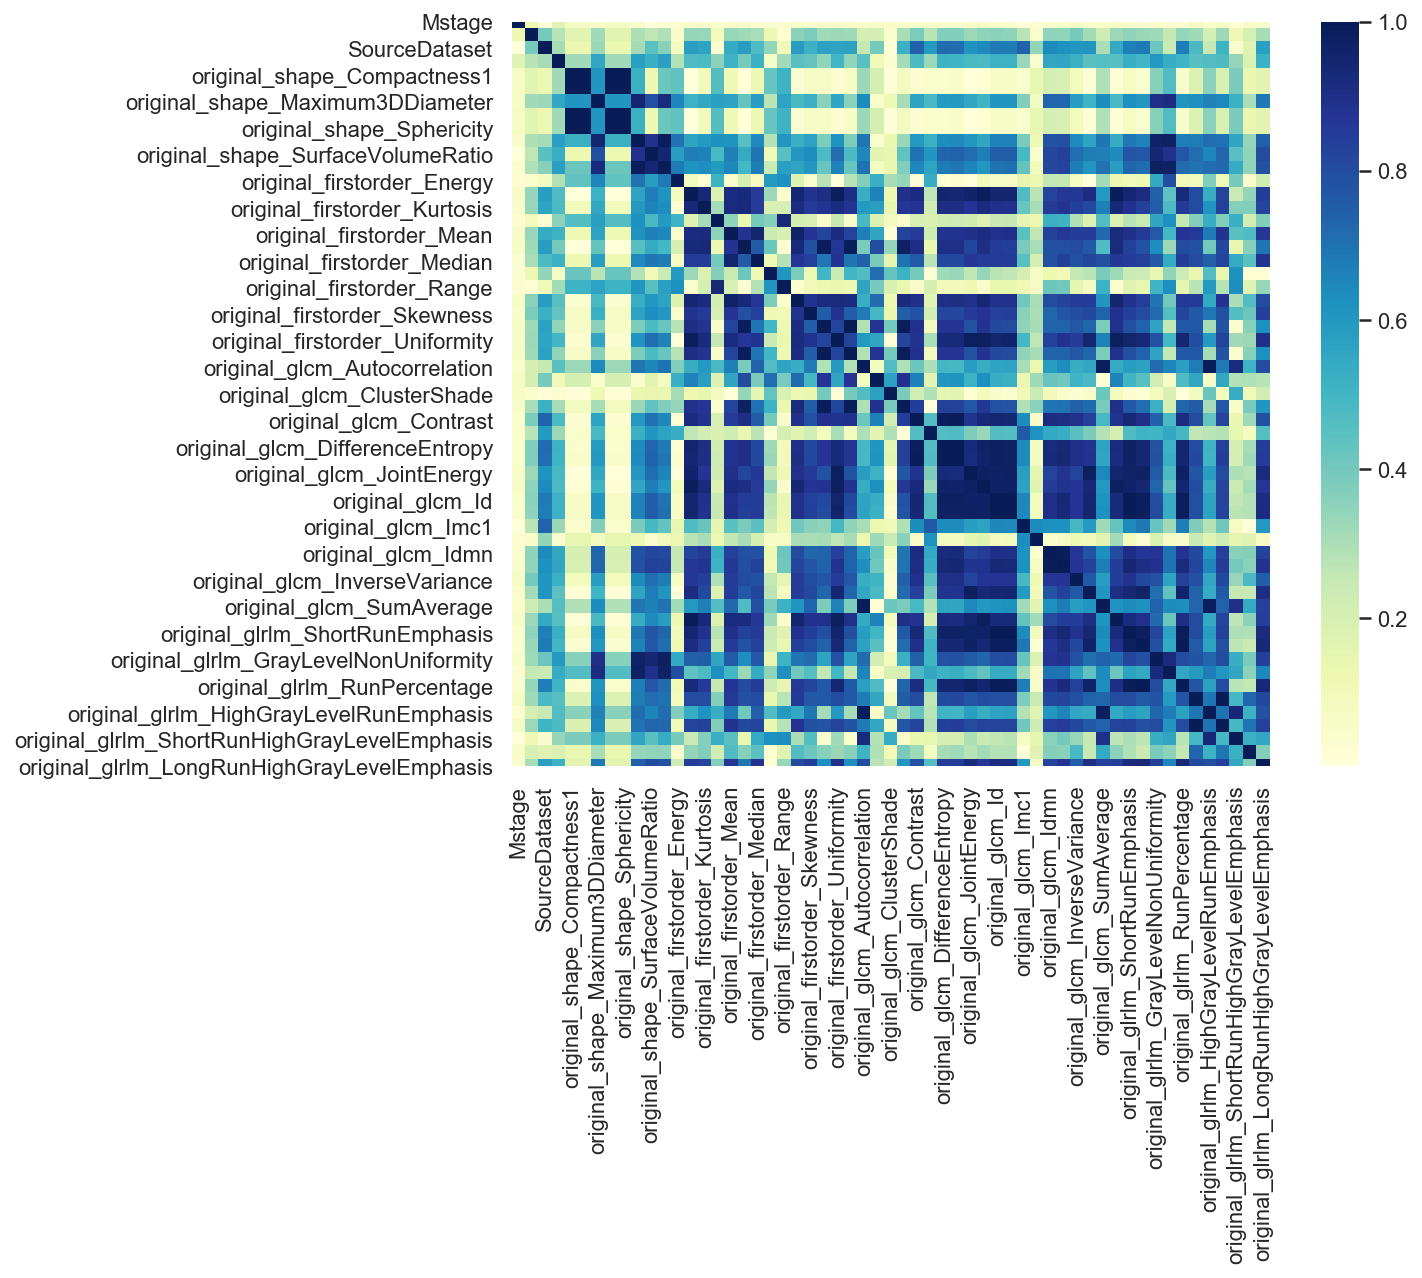

Should drop 37 features - 20 features left


In [3]:
# Filter Method: Spearman's Cross Correlation > 0.9
def corr_feat_selection(dataset, threshold=0.9, plot=False):
    
    # Build correlation matrix
    corr_matrix_spearman = dataset.corr(method="spearman").abs()

    # Draw the heatmap
    sns.set(font_scale = 1.0)
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr_matrix_spearman, cmap= "YlGnBu", square=True, ax=ax)
    f.tight_layout()
    plt.show()
    
    # Select upper triangle of matrix
    upper = corr_matrix_spearman.where(np.triu(np.ones(corr_matrix_spearman.shape), k = 1).astype(np.bool))

    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Should drop {len(to_drop)} features - {len(upper.columns) - len(to_drop)} features left")
    return to_drop

to_drop = corr_feat_selection(train, threshold=0.9)

# Drop features
X = train.copy().drop(to_drop, axis=1)
X.insert(loc=len(X.columns), column='Event', value=output['Event']) # add 'Event' column at the end
Y = output['SurvivalTime']

##### Removing highly correlated variables allowed us to remove more than half of the features. We now develop more problem-related methods to get a final feature selection.

### Feature Selection based on KM estimator
We saw that we can observe a discrepancy between KM survival functions when discriminating over a single variable (we did it for ```SourceDataset``` variable). 
We follow up on this intuition by quantifying the 'distance' between the  KM survival functions estimates and we define a 'score' associated to a feature as the area between the two graphs (taking the confidence interval provided by the estimator into account). This function is defined as ```KME_score``` in ```utils.py```.

In the following, we plot the discrepancy between survival functions for each remaining features and indicate its score.

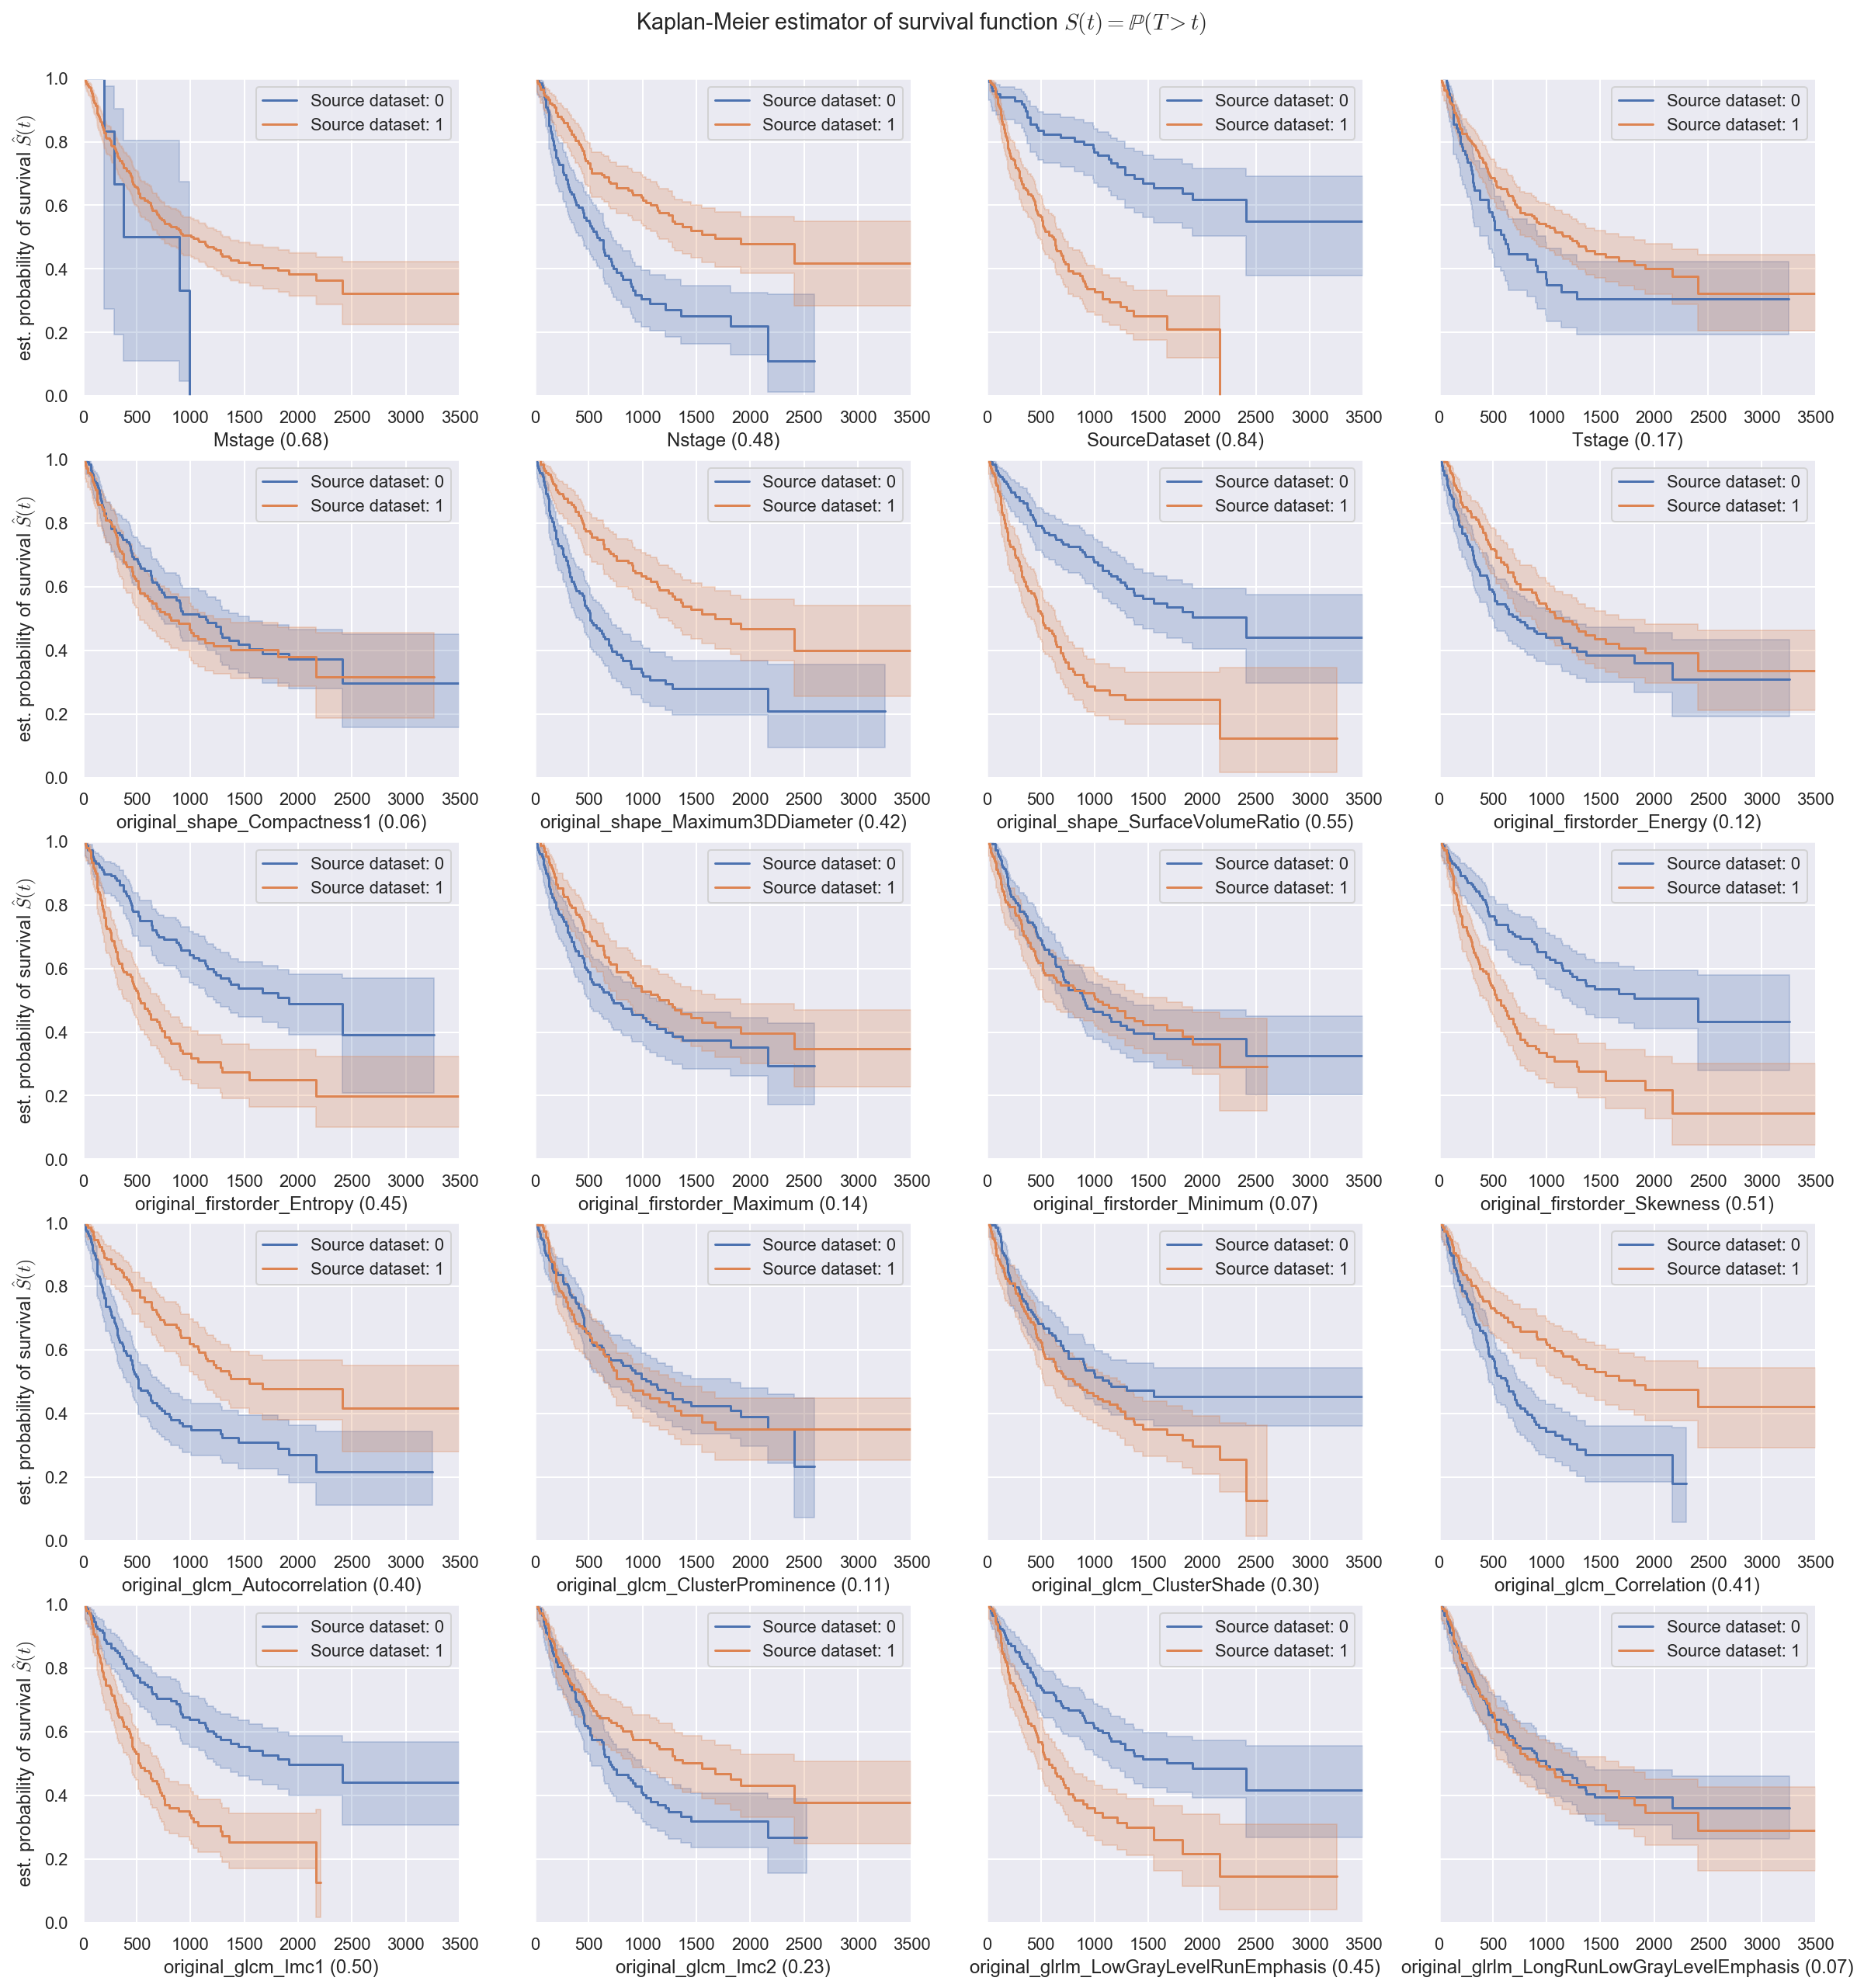

In [11]:
n_feat = len(X.columns) - 1 # don't plot for the feature 'Event'
kmf = KaplanMeierFitter()

fig, axes = plt.subplots((n_feat + 3) // 4, 4, figsize=(20, 20), sharey=True)
j = 0
for feature in X.columns:
    if feature == 'Event':
        continue
    ax = axes[j // 4][j % 4]
    j += 1
    source_mask = (X[feature] > np.median(X[feature]))
    
    kmf.fit(output.SurvivalTime[source_mask], event_observed=output.Event[source_mask], label="Source dataset: 0")
    c1 = kmf.confidence_interval_
    kmf.plot(ax=ax)
    kmf.fit(output.SurvivalTime[~source_mask], event_observed=output.Event[~source_mask], label="Source dataset: 1")
    c2 = kmf.confidence_interval_
    kmf.plot(ax=ax)

    ax.set_ylim(0, 1);
    ax.set_ylabel("est. probability of survival $\hat{S}(t)$")
    ax.set_xlabel(feature  + " ({:.2f})".format(KME_score(c1, c2)))
plt.suptitle("Kaplan-Meier estimator of survival function $S(t) = \mathbb{P}(T>t)$")
fig.subplots_adjust(top=0.95)
plt.show()

We can conjecture that the larger the gap is (and so the score), the more information is contained in the feature, which suggests eliminating the features with the smallest scores.

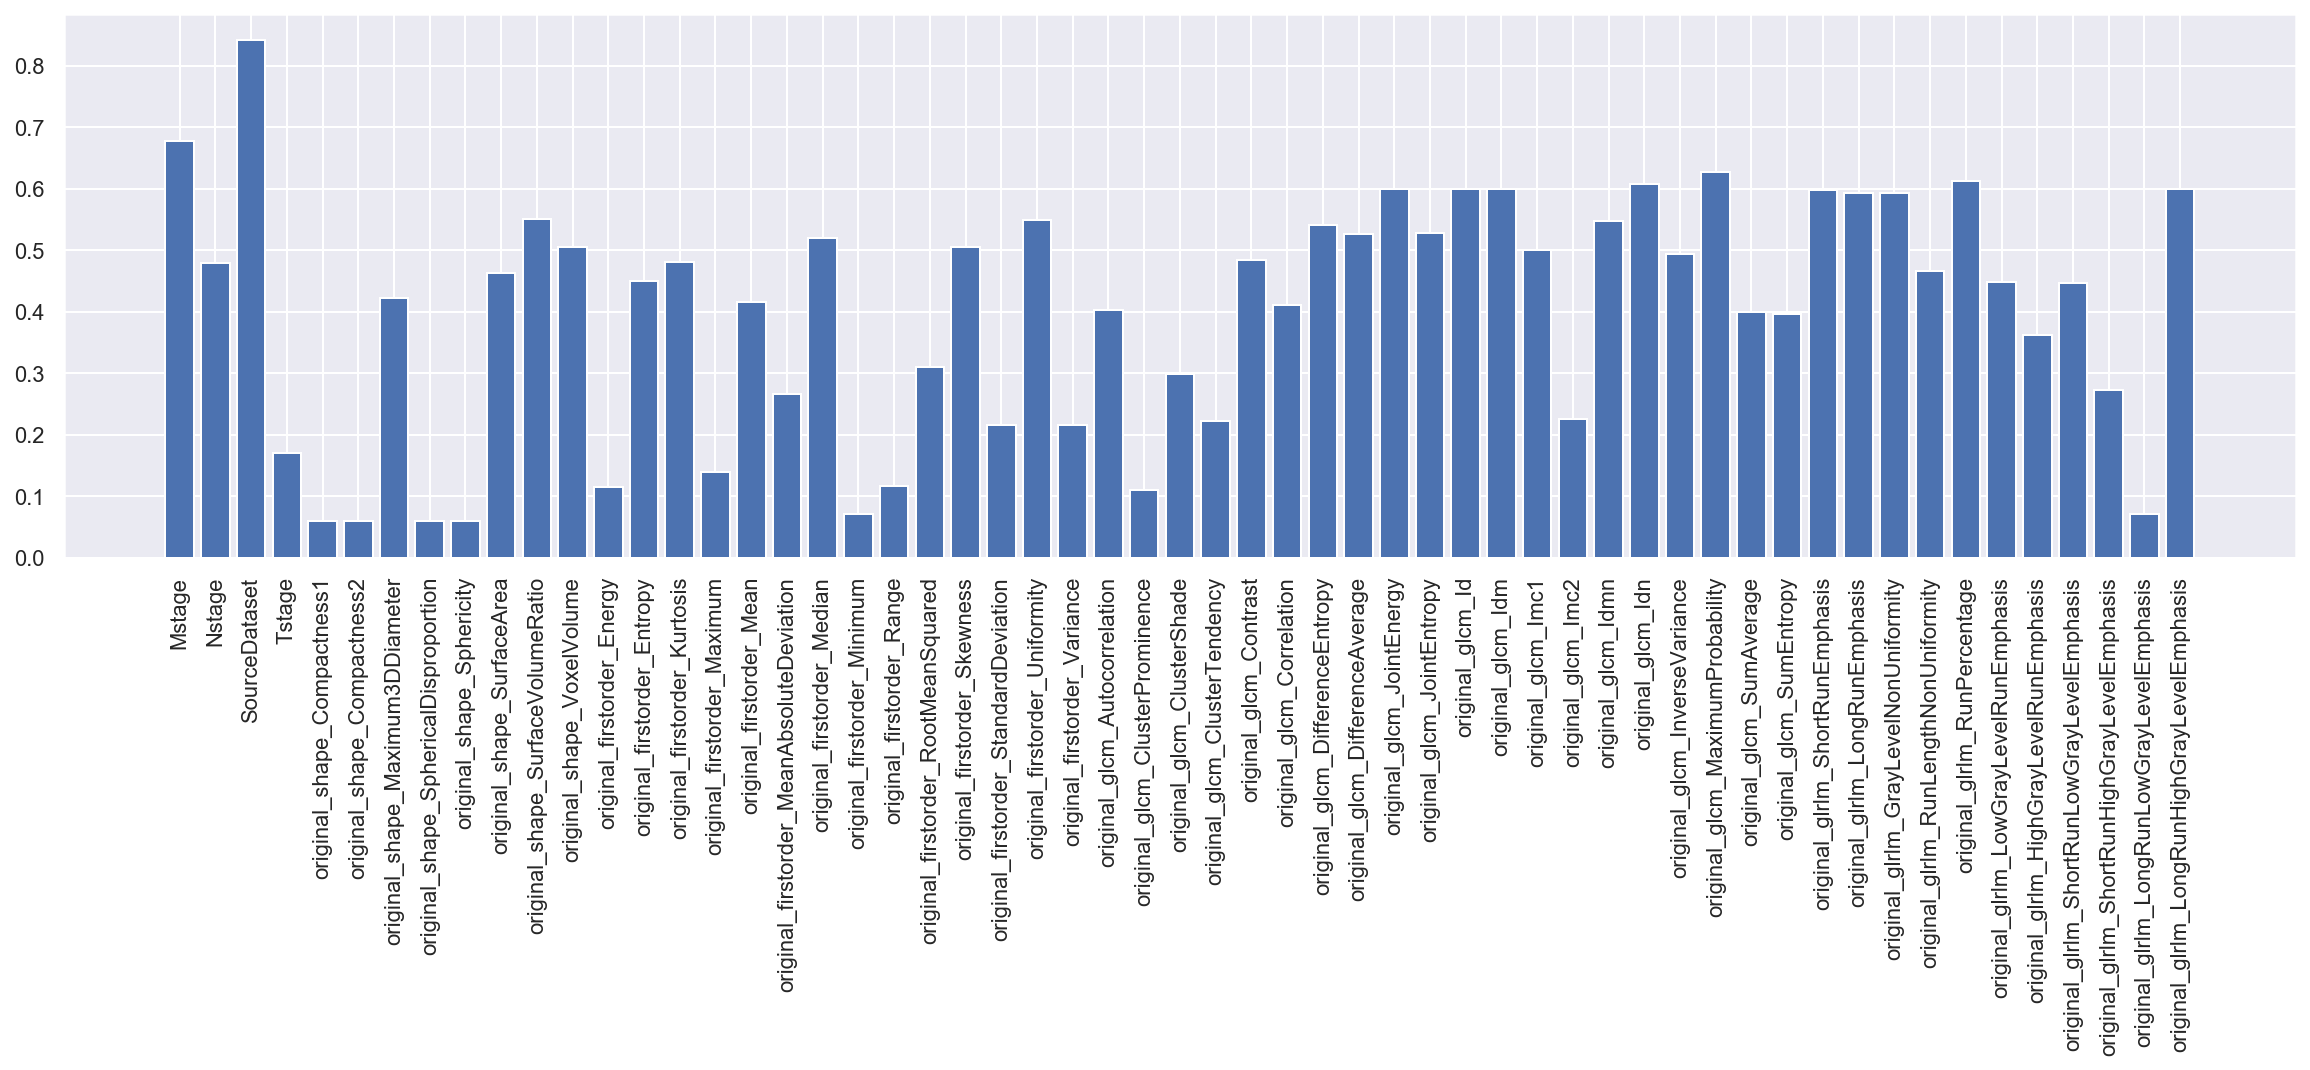

In [321]:
abc = {}
features = list(train.columns)
if 'Event' in features:
    features.remove('Event')
    
for feature in features:
    if feature == 'Event':
        continue
    source_mask = (train[feature] > np.median(train[feature]))

    c1 = kmf.fit(output.SurvivalTime[source_mask], event_observed=output.Event[source_mask], label="Source dataset: 0").confidence_interval_
    c2 = kmf.fit(output.SurvivalTime[~source_mask], event_observed=output.Event[~source_mask], label="Source dataset: 1").confidence_interval_
    abc[feature] = KME_score(c1, c2)

plt.figure(figsize=(20, 5))
plt.bar(np.arange(len(abc)), abc.values(), tick_label=features)
plt.xticks(np.arange(len(abc)), rotation='vertical')
plt.show()

### Feature Selection based on p-values
Another possibility to select the more relevant features is to recursively eliminate variables based on its associated p-value, in the case it is provided (and it is notably for ```CoxPHFitter```).

We can also perform first coarse-grained selection based on KM-score before doing a more fine-grained one using p-value indicator.

## 4. Model Selection
We first create a dictionary of potential model we want to consider (not knowing *a priori* which one would be the more predictive on our specific task), and a dictionary containing the hyperparameters to tune for each of them.

In [37]:
regressors = {}

# -- Cox’s proportional hazard model --
regressors.update({"CoxPH": sklearn_adapter(CoxPHFitter, event_col='Event', predict_method="predict_median")()})

# -- Aalen’s Additive model -- : like the Cox model, it defines the hazard rate, 
# but instead of the linear model being multiplicative, this model is additive
regressors.update({"AalenAdditive": sklearn_adapter(AalenAdditiveFitter, event_col='Event', predict_method="predict_median")()})

# -- Weibfull Accelerated failure time model -- : assume parametric form for the survival function S(t) 
# (with underlying Weibfull distribution in this case).
regressors.update({"WeibullAFT": sklearn_adapter(WeibullAFTFitter, event_col='Event', predict_method="predict_median")()})

# Initiate parameter grid
parameters = {}

parameters.update({"CoxPH": {"penalizer": 10.0 ** np.arange(-2, 2)
                                         }})

parameters.update({"AalenAdditive": {"penalizer": 10.0 ** np.arange(-2, 3),
                                     "smoothing_penalizer": 10.0 ** np.arange(-2, 1)
                                         }})

parameters.update({"WeibullAFT": {"penalizer": 10.0 ** np.arange(-1, 3),
                           "l1_ratio": [0, 1/3, 2/3],
                           "model_ancillary": [True, False],
                        }})

tuned_regressors = {}

### Grid search hyperparameter tuning
The following function is a wrapper to the ```GridSearchCV```function from ```sklearn``` adapted to ```lifelines``` regressors.

In [14]:
def gs_tuning(X, Y, regressor_id="CoxPH", cv=4, verbose=1, get_best_score=False):
    selected_regressor = regressor_id
    regressor = regressors[selected_regressor]

    # Get associated parameter grid
    param_grid = parameters[selected_regressor]

    gscv = GridSearchCV(regressor, param_grid, cv=cv, verbose=verbose)

    # Fit gscv
    print(f"Tuning {selected_regressor}.")
    gscv.fit(X, Y)  

    # Get best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_

    print("\t- Best score: {:.3f} \n\t- Best permeters: {}".format(best_score, best_params))

    # Update regressor parameters
    tuned_params = {item: best_params[item] for item in best_params}
    regressor.set_params(**tuned_params)
    
    if get_best_score:
        return regressor, best_score
    return regressor

### Exemple: Cox model

Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.686 
	- Best permeters: {'penalizer': 10.0}


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s finished


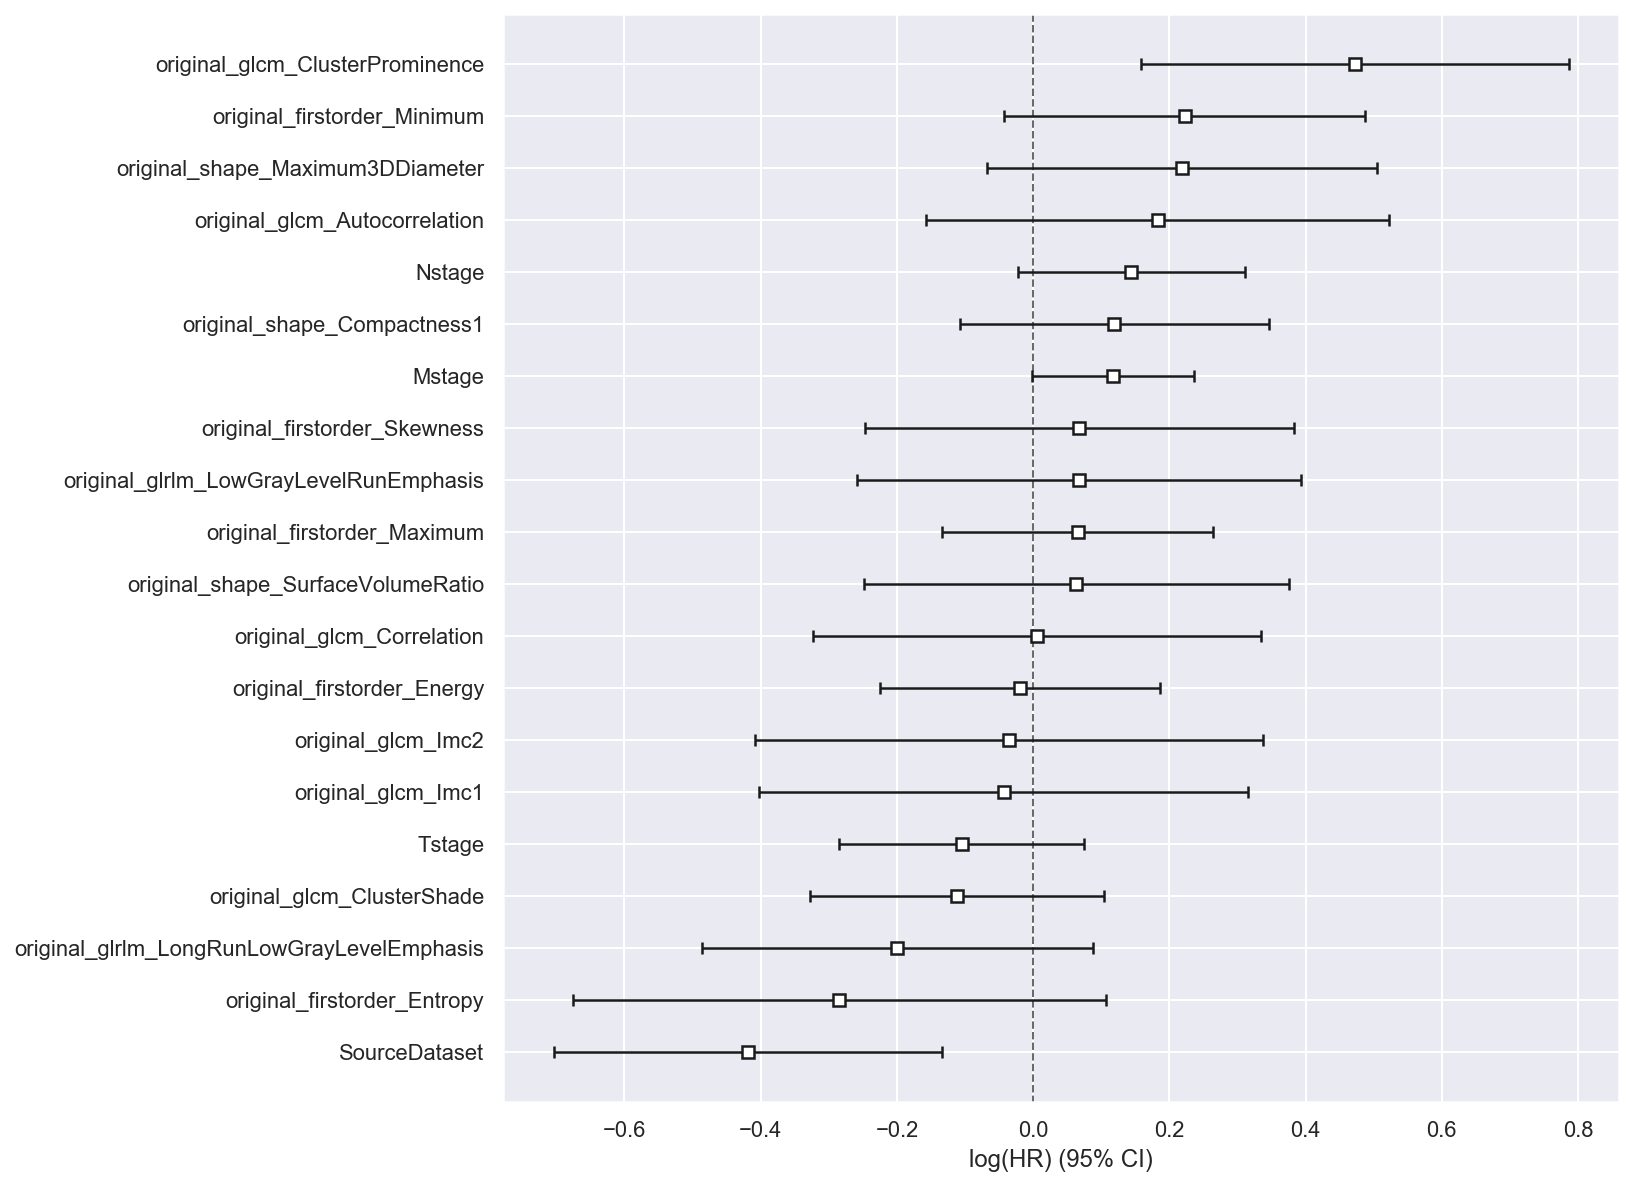

In [15]:
regressor = gs_tuning(X, Y, "CoxPH")
regressor.fit(X, Y)
regressor.lifelines_model.print_summary()
fig, ax = plt.subplots(figsize=(10, 10))
regressor.lifelines_model.plot(ax=ax)
plt.show()

In [18]:
print("c-index score: {:.3f}".format(regressor.lifelines_model.score_))

c-index score: 0.722


## 5. Model & Feature selection
We implement methods selecting features by recursive elimination (either based on the KM-score or the p-value) and finding the 'best' hyper-parameters.

### KM-score + cross validaiton

In [24]:
def KME_feature_selection(X, n_features=10, threshold=None, get_all=False):
    if get_all:
        print("Getting each feature with its rank according to KME")
    elif threshold is not None:
        print("Select features using threshold")
    elif n_features >= len(X.columns):
        print("Less features ({}) in dataset than the required number ({})".format(len(X.columns), n_features))
    else:
        print("Selecting {1} features out of {0}".format(len(X.columns), n_features))
        
    labels, KMEscore = [], []

    for feature in X.columns:
        if feature == 'Event':
            continue
        source_mask = (X[feature] > np.median(X[feature]))
        
        kmf = KaplanMeierFitter()
        c1 = kmf.fit(output.SurvivalTime[source_mask], event_observed=output.Event[source_mask], label="Source dataset: 0").confidence_interval_
        c2 = kmf.fit(output.SurvivalTime[~source_mask], event_observed=output.Event[~source_mask], label="Source dataset: 1").confidence_interval_
        
        labels.append(feature)
        KMEscore.append(KME_score(c1, c2))
    
    ind = np.argsort(KMEscore)
    
    if not get_all:
        # Keep the largest
        return np.array(labels)[ind][:-n_features]
    
    return np.array(labels), ind
    

In [59]:
def optimize1(X, Y, model_id, n_features_s):
    X_reg = X.copy()
    best_score = -1
    best_regressor = None
    best_n_features = n_features_s[0]
    labels, ind_asc = KME_feature_selection(X, get_all=True)
    labels = labels[ind_asc]
    labels_to_drop = labels[:-n_features_s[0]]
    for n_features in n_features_s:
        print("Tuning {} with {} features".format(model_id, n_features))
        X_reg = X_reg.drop(labels_to_drop, axis=1)
        assert len(X_reg.columns) - 1 == n_features # column 'Event' is not a feature
        trial = 0
        while True:
            try:
                regressor, score = gs_tuning(X_reg, Y, model_id, get_best_score=True)
                break
            except BaseException as err:
                print("Error {} occured, retrying for the {} time".format(err, trial + 1))
                trial += 1
                if trial > 5:
                    print("Give up")
                    break
        if score > best_score:  # would be more relevant to consider AIC as the number of parameters has decreased
            best_score = score
            best_n_features = n_features
            best_regressor = clone(regressor)
        labels_to_drop = labels[-n_features + 1]
    best_labels = list(labels[-best_n_features:])
    best_labels.append('Event')
    return best_regressor, best_labels

#### Test on AalenAdditive model

In [26]:
regressor_id = 'AalenAdditive'
regressor, features = optimize1(X, Y, regressor_id, np.arange(12, 5, -1))

Getting each feature with its rank according to KME
Tuning AalenAdditive with 12 features
Tuning AalenAdditive.
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.644 
	- Best permeters: {'penalizer': 0.01, 'smoothing_penalizer': 0.01}
Tuning AalenAdditive with 11 features
Tuning AalenAdditive.
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.655 
	- Best permeters: {'penalizer': 0.01, 'smoothing_penalizer': 0.1}
Tuning AalenAdditive with 10 features
Tuning AalenAdditive.
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.659 
	- Best permeters: {'penalizer': 0.01, 'smoothing_penalizer': 0.01}
Tuning AalenAdditive with 9 features
Tuning AalenAdditive.
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.662 
	- Best permeters: {'penalizer': 0.01, 'smoothing_penalizer': 0.01}
Tuning AalenAdditive with 8 features
Tuning AalenAdditive.
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.660 
	- Best permeters: {'penalizer': 0.01, 'smoothing_penalizer': 0.01}
Tuning AalenAdditive with 7 features
Tuning AalenAdditive.
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.666 
	- Best permeters: {'penalizer': 0.01, 'smoothing_penalizer': 0.01}
Tuning AalenAdditive with 6 features
Tuning AalenAdditive.
Fitting 4 folds for each of 15 candidates, totalling 60 fits
	- Best score: 0.656 
	- Best permeters: {'penalizer': 0.01, 'smoothing_penalizer': 1.0}


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.1s finished


In [48]:
regressor.fit(X, Y)
score = regressor.lifelines_model.score_
print("c-index {}: {:.3f}".format(regressor_id, score))
predict(regressor, test, True, filename=regressor_id + '-1', skmodel=True)
features = list(features)
features.remove('Event')
tuned_regressors[regressor_id + '-1'] = [clone(regressor), features.copy(), 1, score]

c-index AalenAdditive: 0.681


#### Same for Cox-model and Weibull

In [49]:
regressor_id = 'CoxPH'
regressor, features = optimize1(X, Y, regressor_id, np.arange(14, 5, -1))
regressor.fit(X, Y)
score = regressor.lifelines_model.score_
print("c-index {}: {:.3f}".format(regressor_id, score))
predict(regressor, test, True, filename=regressor_id + '-1', skmodel=True)
features = list(features)
features.remove('Event')
tuned_regressors[regressor_id + '-1'] = [clone(regressor), features.copy(), 1, score]

Getting each feature with its rank according to KME
Tuning CoxPH with 14 features
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.685 
	- Best permeters: {'penalizer': 10.0}
Tuning CoxPH with 13 features
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.686 
	- Best permeters: {'penalizer': 10.0}
Tuning CoxPH with 12 features
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.676 
	- Best permeters: {'penalizer': 10.0}
Tuning CoxPH with 11 features
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.676 
	- Best permeters: {'penalizer': 10.0}
Tuning CoxPH with 10 features
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.678 
	- Best permeters: {'penalizer': 10.0}
Tuning CoxPH with 9 features
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.678 
	- Best permeters: {'penalizer': 10.0}
Tuning CoxPH with 8 features
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.676 
	- Best permeters: {'penalizer': 10.0}
Tuning CoxPH with 7 features
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.674 
	- Best permeters: {'penalizer': 10.0}
Tuning CoxPH with 6 features
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits
	- Best score: 0.665 
	- Best permeters: {'penalizer': 10.0}
c-index CoxPH: 0.722


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished


In [60]:
regressor_id = 'WeibullAFT'
regressor, features = optimize1(X, Y, regressor_id, np.arange(12, 5, -1))
regressor.fit(X, Y)
score = regressor.lifelines_model.score_
print("c-index {}: {:.3f}".format(regressor_id, score))
predict(regressor, test, True, filename=regressor_id + '-1', skmodel=True)
features = list(features)
features.remove('Event')
tuned_regressors[regressor_id + '-1'] = [clone(regressor), features.copy(), 1, score]

Getting each feature with its rank according to KME
Tuning WeibullAFT with 12 features
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: overflow encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/usr/local/lib/python3.7/site-packages/lifelines/utils/safe_exp.py:92: RuntimeWarning: overflow encountered in multiply
  return lambda g: g * ans
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data

	- Best score: 0.693 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': True, 'penalizer': 1.0}
Tuning WeibullAFT with 11 features
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This cou

	- Best score: 0.690 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': True, 'penalizer': 0.1}
Tuning WeibullAFT with 10 features
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This cou

	- Best score: 0.692 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': True, 'penalizer': 0.1}
Tuning WeibullAFT with 9 features
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This cou

	- Best score: 0.689 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': True, 'penalizer': 0.1}
Tuning WeibullAFT with 8 features
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This cou

	- Best score: 0.688 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': True, 'penalizer': 10.0}
Tuning WeibullAFT with 7 features
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This cou

	- Best score: 0.683 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': True, 'penalizer': 10.0}
Tuning WeibullAFT with 6 features
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: overflow encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/usr/local/lib/python3.7/site-packages/lifelines/utils/safe_exp.py:92: RuntimeWarning: overflow encountered in multiply
  return lambda g: g * ans


     fun: nan
     jac: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
 message: 'Iteration limit exceeded'
    nfev: 2051
     nit: 201
    njev: 201
  status: 9
 success: False
       x: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
Error Fitting did not converge. Try checking the following:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected?
2. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
3. Try using an alternate minimizer: ``fitter._scipy_fit_method = "SLSQP"``.
4. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.
 occured, retrying for the 1 time
Tuning WeibullAFT.
Fitting 4 folds for ea

/usr/local/lib/python3.7/site-packages/lifelines/utils/__init__.py:1106: ConvergenceWarning: Column Mstage have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Mstage'].var())
>>> print(df.loc[~events, 'Mstage'].var())

A very low variance means that the column Mstage completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.


     fun: nan
     jac: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
 message: 'Iteration limit exceeded'
    nfev: 2051
     nit: 201
    njev: 201
  status: 9
 success: False
       x: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
Error Fitting did not converge. Try checking the following:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected?
2. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
3. Try using an alternate minimizer: ``fitter._scipy_fit_method = "SLSQP"``.
4. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.
 occured, retrying for the 2 time
Tuning WeibullAFT.
Fitting 4 folds for ea

/usr/local/lib/python3.7/site-packages/lifelines/utils/__init__.py:1106: ConvergenceWarning: Column Mstage have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Mstage'].var())
>>> print(df.loc[~events, 'Mstage'].var())

A very low variance means that the column Mstage completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.


     fun: nan
     jac: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
 message: 'Iteration limit exceeded'
    nfev: 2051
     nit: 201
    njev: 201
  status: 9
 success: False
       x: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
Error Fitting did not converge. Try checking the following:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected?
2. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
3. Try using an alternate minimizer: ``fitter._scipy_fit_method = "SLSQP"``.
4. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.
 occured, retrying for the 3 time
Tuning WeibullAFT.
Fitting 4 folds for ea

/usr/local/lib/python3.7/site-packages/lifelines/utils/__init__.py:1106: ConvergenceWarning: Column Mstage have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Mstage'].var())
>>> print(df.loc[~events, 'Mstage'].var())

A very low variance means that the column Mstage completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.


     fun: nan
     jac: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
 message: 'Iteration limit exceeded'
    nfev: 2051
     nit: 201
    njev: 201
  status: 9
 success: False
       x: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
Error Fitting did not converge. Try checking the following:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected?
2. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
3. Try using an alternate minimizer: ``fitter._scipy_fit_method = "SLSQP"``.
4. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.
 occured, retrying for the 4 time
Tuning WeibullAFT.
Fitting 4 folds for ea

/usr/local/lib/python3.7/site-packages/lifelines/utils/__init__.py:1106: ConvergenceWarning: Column Mstage have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Mstage'].var())
>>> print(df.loc[~events, 'Mstage'].var())

A very low variance means that the column Mstage completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.


     fun: nan
     jac: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
 message: 'Iteration limit exceeded'
    nfev: 2051
     nit: 201
    njev: 201
  status: 9
 success: False
       x: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
Error Fitting did not converge. Try checking the following:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected?
2. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
3. Try using an alternate minimizer: ``fitter._scipy_fit_method = "SLSQP"``.
4. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.
 occured, retrying for the 5 time
Tuning WeibullAFT.
Fitting 4 folds for ea

/usr/local/lib/python3.7/site-packages/lifelines/utils/__init__.py:1106: ConvergenceWarning: Column Mstage have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Mstage'].var())
>>> print(df.loc[~events, 'Mstage'].var())

A very low variance means that the column Mstage completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.


     fun: nan
     jac: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
 message: 'Iteration limit exceeded'
    nfev: 2051
     nit: 201
    njev: 201
  status: 9
 success: False
       x: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
Error Fitting did not converge. Try checking the following:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected?
2. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
3. Try using an alternate minimizer: ``fitter._scipy_fit_method = "SLSQP"``.
4. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.
 occured, retrying for the 6 time
Give up


/usr/local/lib/python3.7/site-packages/lifelines/utils/__init__.py:1106: ConvergenceWarning: Column Mstage have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Mstage'].var())
>>> print(df.loc[~events, 'Mstage'].var())

A very low variance means that the column Mstage completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.


c-index WeibullAFT: 0.705


### p-value + cross validaiton

In [211]:
def optimize2(X, Y, model_id, threshold=0.05, verbose=1):
    
    X_reg = X.copy()
        
    for _ in range(len(X_reg.columns)):
        
        assert X_reg.columns[-1] == 'Event'
        
        trial=0
        while True:
            try:
                regressor = gs_tuning(X_reg, Y, model_id, verbose=verbose)
                break
            except BaseException as err:
                print("Error {} occured, retrying for the {} time".format(err, trial + 1))
                trial += 1
                if trial > 5:
                    print("Give up")
                    break

        regressor.fit(X_reg, Y)
        
        p_values = regressor.lifelines_model._compute_p_values()
        
        if model_id == 'WeibullAFT': 
            # need to deal with the p-value associated to the rho function of the model
            if regressor.lifelines_model.model_ancillary: 
                assert len(p_values) == 2 * len(X_reg.columns)
                p_val = []
                for i in range(len(X_reg.columns)-1):
                    p_val.append(min(p_values[i], p_values[len(X_reg.columns) + i]))
                p_values = np.array(p_val)
            else:
                p_values = p_values[:-1]
                        
        if max(p_values) <= threshold:
            return regressor, X_reg.columns
        
        ind = np.argmax(p_values)
        col = X_reg.columns[ind]
        if verbose > 0:
            print('---' * 30)
            print("Removing '{}' (p={:.3f}) ## {} features left".format(col, p_values[ind], len(X_reg.columns) - 1))
            print('---' * 30)
        X_reg = X_reg.drop(col, axis=1)
        
    return regressor, X_reg.columns

#### Test with Cox-hazard model

In [140]:
regressor_id = 'CoxPH'
regressor, features = optimize2(X, Y, regressor_id, 0.05)
regressor.fit(X, Y)
score = regressor.lifelines_model.score_
print("c-index {}: {:.3f}".format(regressor_id, score))
predict(regressor, test, True, filename=regressor_id + '-2', skmodel=True)
features = list(features)
features.remove('Event')
tuned_regressors[regressor_id + '-2'] = [clone(regressor), features.copy(), score]

Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.686 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_glcm_Correlation' (p=0.973) ## 20 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.687 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_firstorder_Energy' (p=0.856) ## 19 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.691 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_glcm_Imc2' (p=0.836) ## 18 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.692 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_glcm_Imc1' (p=0.870) ## 17 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.694 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_firstorder_Skewness' (p=0.669) ## 16 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.695 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_shape_SurfaceVolumeRatio' (p=0.633) ## 15 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.699 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_glrlm_LowGrayLevelRunEmphasis' (p=0.551) ## 14 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.699 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_glcm_ClusterShade' (p=0.462) ## 13 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.699 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_firstorder_Maximum' (p=0.528) ## 12 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.700 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'Tstage' (p=0.277) ## 11 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.702 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_shape_Compactness1' (p=0.219) ## 10 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.703 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_firstorder_Entropy' (p=0.207) ## 9 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.701 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_glrlm_LongRunLowGrayLevelEmphasis' (p=0.375) ## 8 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.705 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'Nstage' (p=0.141) ## 7 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.703 
	- Best permeters: {'penalizer': 1.0}
------------------------------------------------------------------------------------------
Removing 'original_shape_Maximum3DDiameter' (p=0.073) ## 6 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits
	- Best score: 0.710 
	- Best permeters: {'penalizer': 0.1}
c-index CoxPH: 0.720


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.9s finished


#### We observe the KM estimates associated to the selected features.

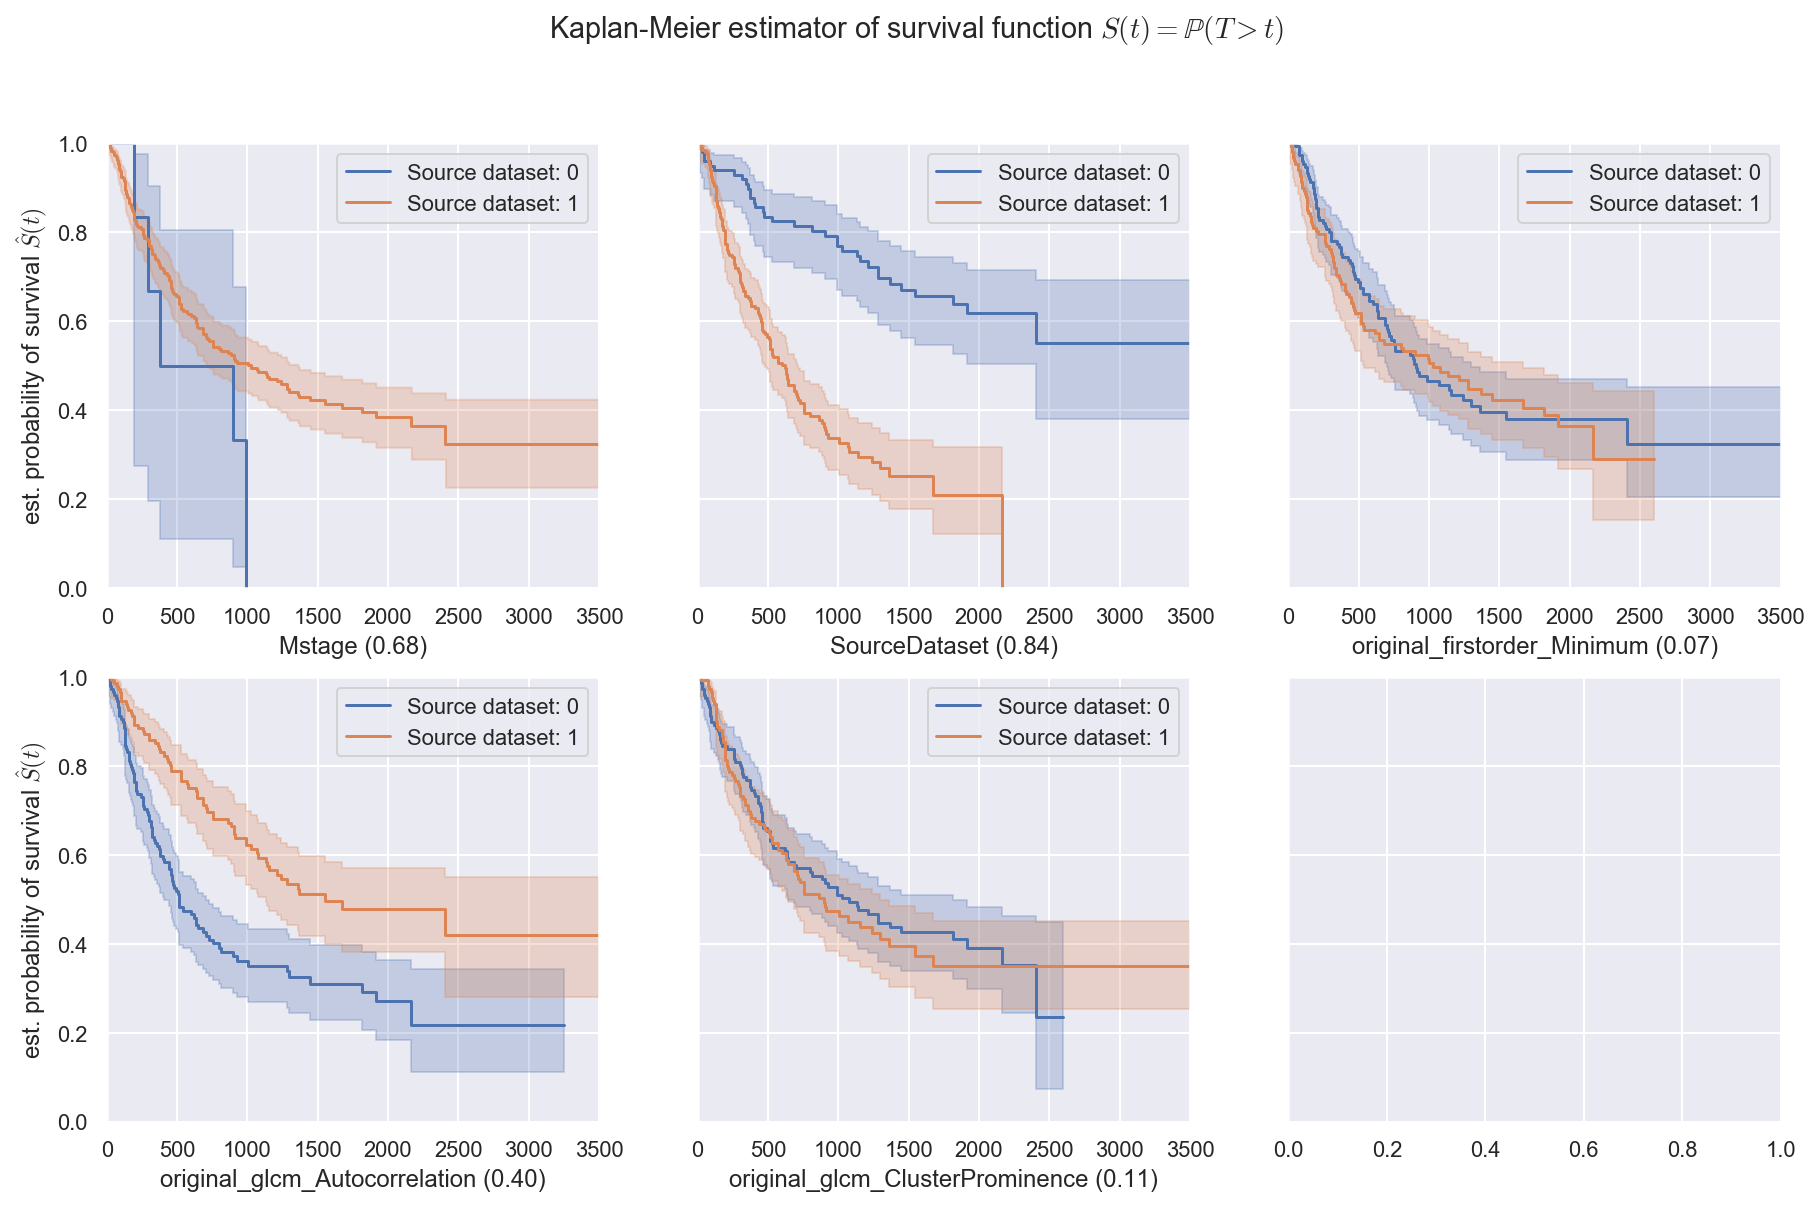

In [141]:
features.append('Event')
n_feat = len(features) - 1
fig, axes = plt.subplots(n_feat // 3 + 1, 3, figsize=(15, 9), sharey=True)
j = 0
for feature in features:
    if feature == 'Event':
        continue
    ax = axes[j // 3][j % 3]
    j += 1
    source_mask = (X[feature] > np.median(X[feature]))

    kmf.fit(output.SurvivalTime[source_mask], event_observed=output.Event[source_mask], label="Source dataset: 0")
    c1 = kmf.confidence_interval_
    kmf.plot(ax=ax)
    kmf.fit(output.SurvivalTime[~source_mask], event_observed=output.Event[~source_mask], label="Source dataset: 1")
    c2 = kmf.confidence_interval_
    kmf.plot(ax=ax)

    ax.set_ylim(0, 1);
    ax.set_ylabel("est. probability of survival $\hat{S}(t)$")
    ax.set_xlabel(feature  + " ({:.2f})".format(KME_score(c1, c2)))
plt.suptitle("Kaplan-Meier estimator of survival function $S(t) = \mathbb{P}(T>t)$")
plt.show()

We observe that for some selected features, the KM-score is really low ($0.07$ for ```original_firstorder_Minimum```). We can try to eliminate them via KM-score filtering before doing selection by p-value-based recursive elimination.

### KM-score + p-value + cross validaiton

In [143]:
def optimize3(X, Y, model_id, n_features, threshold=0.05, verbose=1):
    X_reg = X.copy()
    
    to_drop = KME_feature_selection(X_reg, n_features)
    X_reg = X_reg.drop(to_drop, axis=1)
    
    return optimize2(X_reg, Y, model_id, threshold=threshold, verbose=verbose)

#### Test with Cox-hazard model

In [74]:
regressor_id = 'CoxPH'
regressor, features = optimize3(X, Y, regressor_id, 15, threshold=0.1) 
regressor.fit(X, Y)
score = regressor.lifelines_model.score_
print("c-index {}: {:.3f}".format(regressor_id, score))
predict(regressor, test, True, filename=regressor_id + '-3', skmodel=True)
features = list(features)
features.remove('Event')
tuned_regressors[regressor_id + '-3'] = [clone(regressor), features.copy(), 2, score]

Selecting 15 features out of 21
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.688 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_shape_SurfaceVolumeRatio' (p=0.939) ## 15 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.692 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_glcm_Correlation' (p=0.835) ## 14 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.694 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_glcm_Imc2' (p=0.821) ## 13 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.697 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_glcm_Imc1' (p=0.671) ## 12 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.698 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_firstorder_Skewness' (p=0.468) ## 11 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.698 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_glcm_Autocorrelation' (p=0.456) ## 10 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.699 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'Tstage' (p=0.505) ## 9 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.699 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'original_shape_Maximum3DDiameter' (p=0.315) ## 8 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.701 
	- Best permeters: {'penalizer': 1.0}
------------------------------------------------------------------------------------------
Removing 'original_glrlm_LowGrayLevelRunEmphasis' (p=0.275) ## 7 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


	- Best score: 0.697 
	- Best permeters: {'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'Mstage' (p=0.115) ## 6 features left
------------------------------------------------------------------------------------------
Tuning CoxPH.
Fitting 4 folds for each of 4 candidates, totalling 16 fits
	- Best score: 0.700 
	- Best permeters: {'penalizer': 10.0}
c-index CoxPH: 0.722


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.9s finished


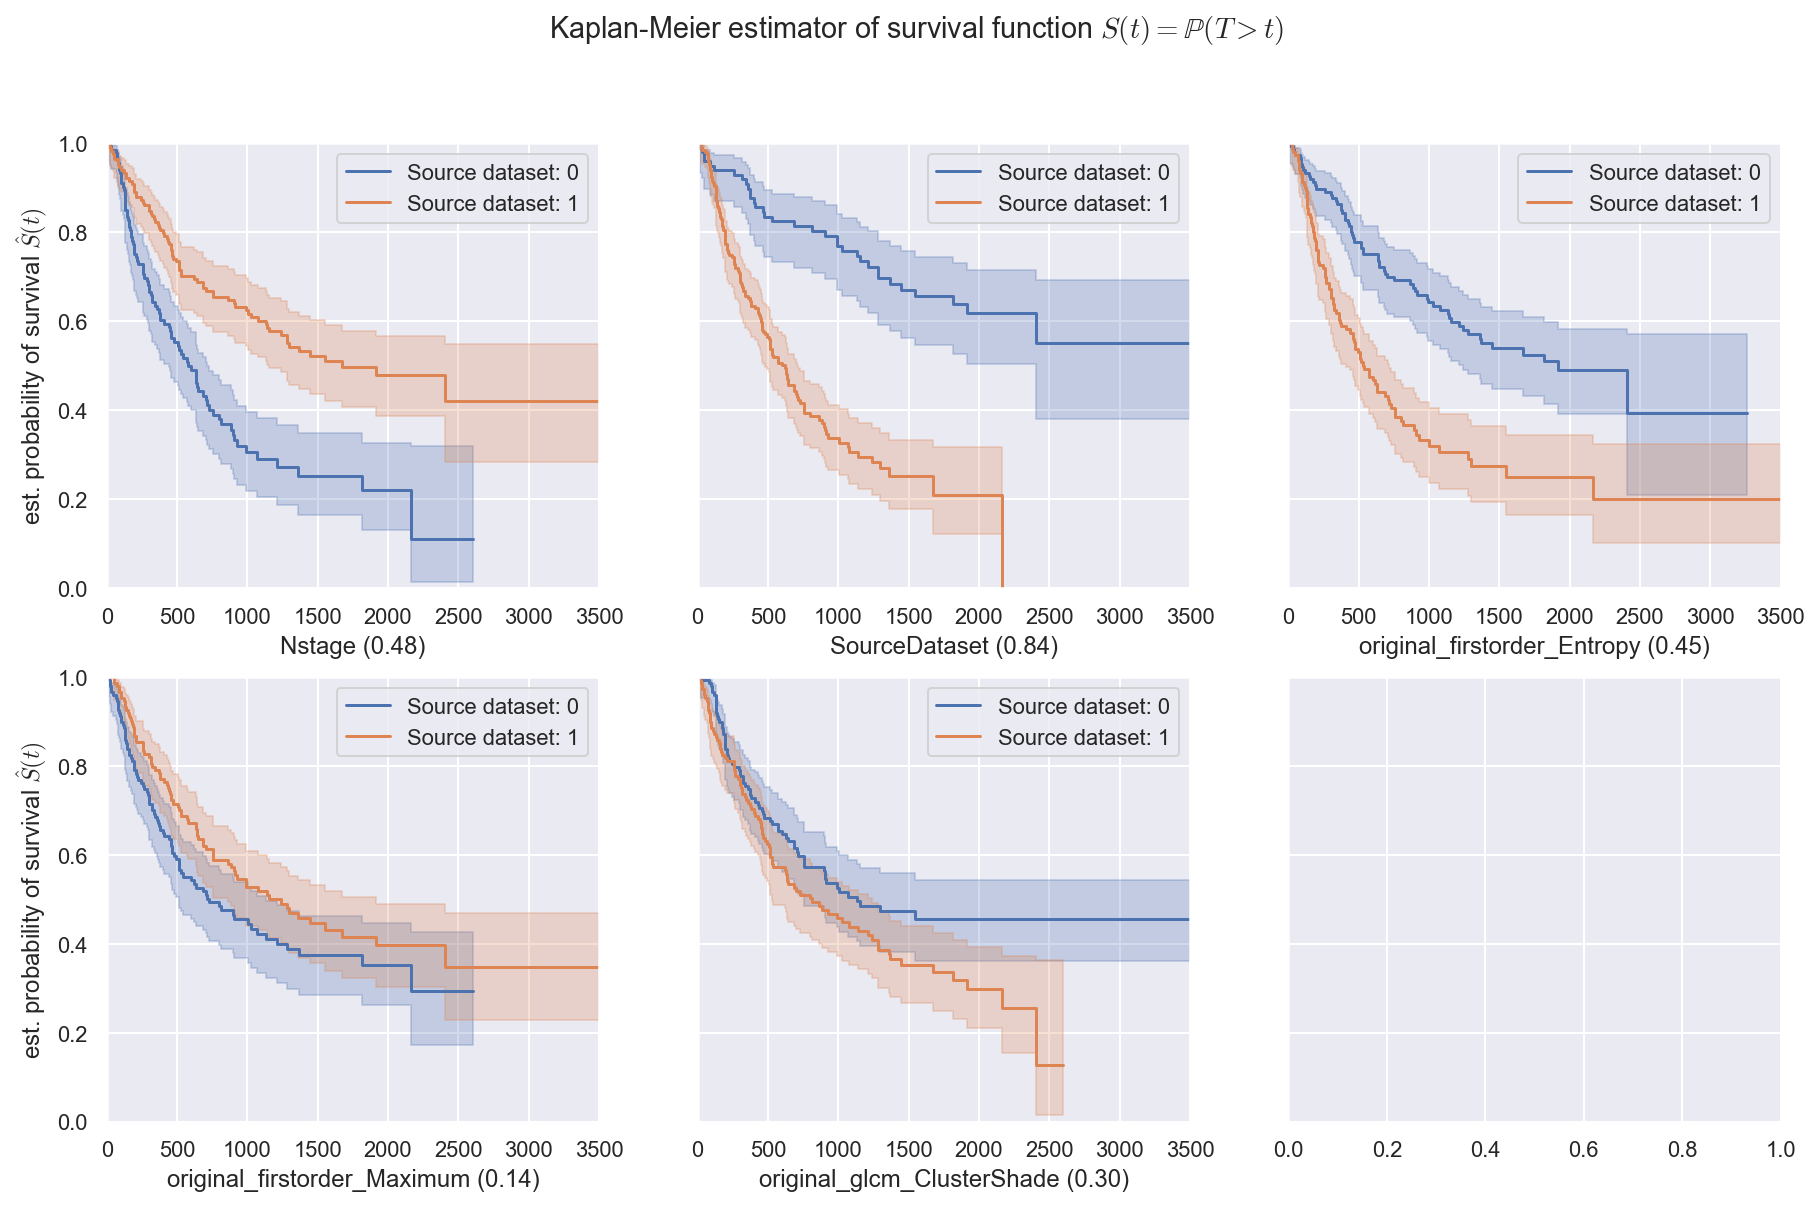

In [75]:
features.append('Event')
n_feat = len(features) - 1
fig, axes = plt.subplots(n_feat // 3 + 1, 3, figsize=(15, 9), sharey=True)
j = 0
for feature in features:
    if feature == 'Event':
        continue
    ax = axes[j // 3][j % 3]
    j += 1
    source_mask = (X[feature] > np.median(X[feature]))

    kmf.fit(output.SurvivalTime[source_mask], event_observed=output.Event[source_mask], label="Source dataset: 0")
    c1 = kmf.confidence_interval_
    kmf.plot(ax=ax)
    kmf.fit(output.SurvivalTime[~source_mask], event_observed=output.Event[~source_mask], label="Source dataset: 1")
    c2 = kmf.confidence_interval_
    kmf.plot(ax=ax)

    ax.set_ylim(0, 1);
    ax.set_ylabel("est. probability of survival $\hat{S}(t)$")
    ax.set_xlabel(feature  + " ({:.2f})".format(KME_score(c1, c2)))
plt.suptitle("Kaplan-Meier estimator of survival function $S(t) = \mathbb{P}(T>t)$")
plt.show()

#### Test with Weibull model

In [212]:
regressor_id = 'WeibullAFT'
regressor, features = optimize3(X, Y, regressor_id, 12, threshold=0.1)
regressor.fit(X, Y)
score = regressor.lifelines_model.score_
print("c-index {}: {:.3f}".format(regressor_id, score))
predict(regressor, test, True, filename=regressor_id + '-3', skmodel=True)
features = list(features)
features.remove('Event')
tuned_regressors[regressor_id + '-3'] = [clone(regressor), features.copy(), 2, score]

Selecting 12 features out of 21
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: overflow encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/usr/local/lib/python3.7/site-packages/lifelines/utils/safe_exp.py:92: RuntimeWarning: overflow encountered in multiply
  return lambda g: g * ans
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data

	- Best score: 0.693 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': True, 'penalizer': 1.0}
------------------------------------------------------------------------------------------
Removing 'original_firstorder_Skewness' (p=0.451) ## 12 features left
------------------------------------------------------------------------------------------
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This cou

	- Best score: 0.693 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': True, 'penalizer': 1.0}
------------------------------------------------------------------------------------------
Removing 'original_shape_SurfaceVolumeRatio' (p=0.319) ## 11 features left
------------------------------------------------------------------------------------------
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This cou

	- Best score: 0.695 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': True, 'penalizer': 1.0}
------------------------------------------------------------------------------------------
Removing 'original_glrlm_LowGrayLevelRunEmphasis' (p=0.287) ## 10 features left
------------------------------------------------------------------------------------------
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This cou

	- Best score: 0.695 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': False, 'penalizer': 1.0}
------------------------------------------------------------------------------------------
Removing 'original_glcm_ClusterShade' (p=0.392) ## 9 features left
------------------------------------------------------------------------------------------
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   39.4s finished


	- Best score: 0.694 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': True, 'penalizer': 1.0}
------------------------------------------------------------------------------------------
Removing 'original_glcm_Correlation' (p=0.114) ## 8 features left
------------------------------------------------------------------------------------------
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: overflow encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/usr/local/lib/python3.7/site-packages/lifelines/utils/safe_exp.py:92: RuntimeWarning: overflow encountered in multiply
  return lambda g: g * ans
/usr/local/lib/python3.7/site-packages/lifelines/fitters/__init__.py:1743: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)
/usr/local/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: overflow encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/usr/local/lib/python3.7/site-packages/

	- Best score: 0.694 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': False, 'penalizer': 10.0}
------------------------------------------------------------------------------------------
Removing 'Mstage' (p=0.687) ## 7 features left
------------------------------------------------------------------------------------------
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: overflow encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/usr/local/lib/python3.7/site-packages/lifelines/utils/safe_exp.py:92: RuntimeWarning: overflow encountered in multiply
  return lambda g: g * ans
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   35.8s finished


	- Best score: 0.692 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': False, 'penalizer': 100.0}
------------------------------------------------------------------------------------------
Removing 'Nstage' (p=0.754) ## 6 features left
------------------------------------------------------------------------------------------
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   29.9s finished


	- Best score: 0.681 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': False, 'penalizer': 0.1}
------------------------------------------------------------------------------------------
Removing 'original_firstorder_Entropy' (p=0.471) ## 5 features left
------------------------------------------------------------------------------------------
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   29.6s finished


	- Best score: 0.680 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': True, 'penalizer': 100.0}
------------------------------------------------------------------------------------------
Removing 'original_shape_Maximum3DDiameter' (p=0.738) ## 4 features left
------------------------------------------------------------------------------------------
Tuning WeibullAFT.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   26.9s finished


	- Best score: 0.679 
	- Best permeters: {'l1_ratio': 0, 'model_ancillary': True, 'penalizer': 1.0}
c-index WeibullAFT: 0.705


### Voting Estimator

In the following, we compare c-index yielded by each of our trained models and implement a 'voting regressor' that averages the predictions of each model.

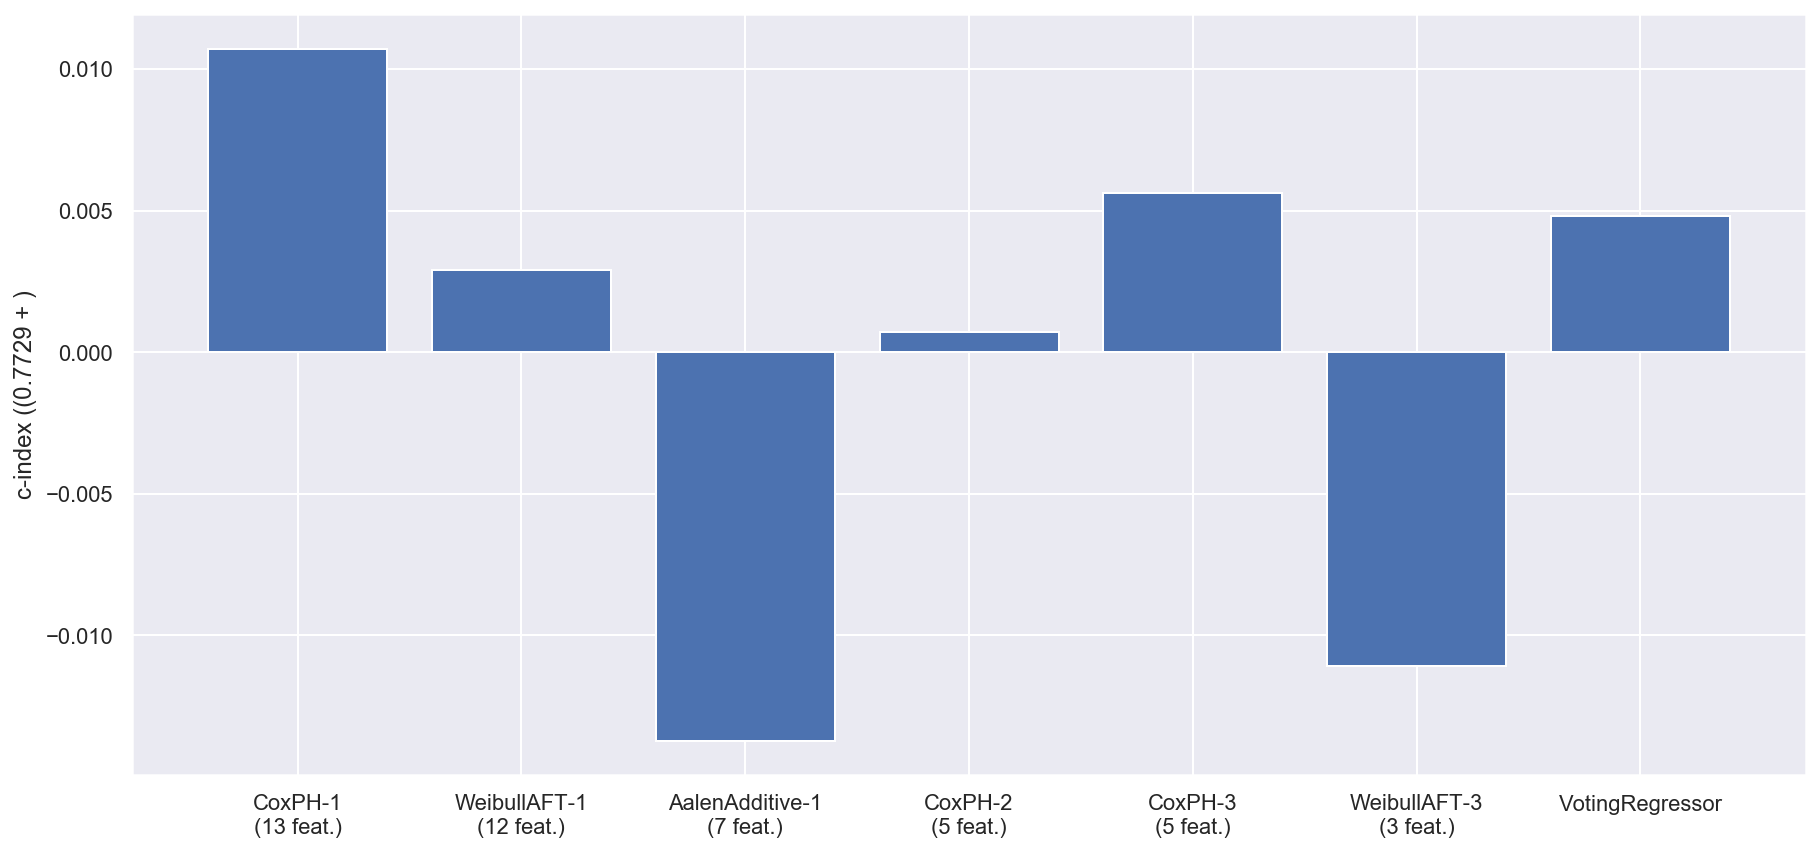

In [298]:
plt.figure(figsize=(15, 7))

voting_prediction = pd.DataFrame(0, index=output.index, columns=output.columns)
voting_prediction['Event'] = output['Event']
regressor_ids = []
scores = []
models = []

for regressor_id, item in tuned_regressors.items():
    regressor_ids.append(regressor_id)
    regressor, features = item[:2]
    regressor.fit(X[features + ['Event']], Y)
    prediction = predict(regressor, train, save=False, skmodel=True)
    prediction['Event'] = output['Event']
    voting_prediction[regressor_id] = prediction['SurvivalTime']
    score = cindex(prediction, output)
    scores.append(score)
    models.append(regressor_id + "\n({} feat.)".format(len(features)))
    
def rank(a, columns):
    for col in columns:
        a[col] = rankdata(a[col], method='min')
    return a[columns]

voting_prediction['SurvivalTime'] = np.median(rank(voting_prediction, columns=regressor_ids), axis=1)
voting_prediction = voting_prediction.drop(regressor_ids, axis=1)
score = cindex(voting_prediction, output)
scores.append(score)
models.append('VotingRegressor')

plt.bar(np.arange(len(scores)), scores-np.mean(scores), tick_label=models)
plt.ylabel("c-index (({:.4f} + )".format(np.mean(scores)))
plt.show()

Regressor with best performance (with a very slight margin) is the CoxPh model tuned by KM-score elimination. We notice that it is the one using the more features so there is a risk of overfitting. Given the margins, we cannot exclude that regressors taking less features into account could perform better on the test set.

In [299]:
def VotingPredict(fitted_regressors, dataset):
    voting_prediction = pd.DataFrame(index=dataset.index, columns=['SurvivalTime', 'Event'])
    voting_prediction['Event'] = 'nan'
    i = 0
    cols = []
    for regressor in fitted_regressors:
        i += 1
        cols.append(str(i))
        prediction = predict(regressor, dataset, save=False, skmodel=True)
        voting_prediction[str(i)] = prediction['SurvivalTime']

    voting_prediction['SurvivalTime'] = np.median(rank(voting_prediction, columns=cols), axis=1)
    voting_prediction = voting_prediction.drop(cols, axis=1)
    return voting_prediction

In [255]:
VotingPredict([val[0] for k, val in tuned_regressors.items() if k in ['WeibullAFT-3', 'AalenAdditive-0', 'CoxPH-3']], test).to_csv('predictions/voting.csv')

#### Save models as json file

In [ ]:
tuned_regressors_to_json(tuned_regressors)

## Final result

We reached the best score on test data with 'WeibullAFT-1' model : c-index = 0.7127 (we had 0.7069 reproducing the basic Cox-hazard baseline with pre-selected features)